# Functioning Water Pumps

The subsaharan nation of Tanzania has had a long history of issues surround potable drinking water. A significant percentage of the nation's inhabitants lack access to clean water for drinking and basic sanitation. This is well recognized by the global community as the vast majority of funding for Water infrastructure came from outside the country. Furthermore, close to 40% of water pumps are operational throughout the nation. The purpose of this model is to predict which water pumps are non-functioning or in need of repair to better allocate resources towards maintenance. 

In [1]:
%cd .. 
%cd data

/Users/azel/github/Tanzanian_Water_Pumps
/Users/azel/github/Tanzanian_Water_Pumps/data


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [3]:
data         = pd.read_csv('train_features.csv')
feature_info = pd.read_csv('train_labels.csv')

feature_info = feature_info.drop(columns = 'id')

df = pd.concat([data, feature_info], sort = False, axis = 1)

In [4]:
df.head()

id  amount_tsh date_recorded        funder  gps_height     installer  \
0  69572      6000.0    2011-03-14         Roman        1390         Roman   
1   8776         0.0    2013-03-06       Grumeti        1399       GRUMETI   
2  34310        25.0    2013-02-25  Lottery Club         686  World vision   
3  67743         0.0    2013-01-28        Unicef         263        UNICEF   
4  19728         0.0    2011-07-13   Action In A           0       Artisan   

   longitude   latitude              wpt_name  num_private  ... water_quality  \
0  34.938093  -9.856322                  none            0  ...          soft   
1  34.698766  -2.147466              Zahanati            0  ...          soft   
2  37.460664  -3.821329           Kwa Mahundi            0  ...          soft   
3  38.486161 -11.155298  Zahanati Ya Nanyumbu            0  ...          soft   
4  31.130847  -1.825359               Shuleni            0  ...          soft   

  quality_group      quantity  quantity_group                source  \
0          good        enough          enough                spring   
1          good  insufficient    insufficient  rainwater harvesting   
2          good        enough          enough                   dam   
3          good           dry             dry           machine dbh   
4          good      seasonal        seasonal  rainwater harvesting   

            source_type source_class              waterpoint_type  \
0                spring  groundwater           communal standpipe   
1  rainwater harvesting      surface           communal standpipe   
2                   dam      surface  communal standpipe multiple   
3              borehole  groundwater  communal standpipe multiple   
4  rainwater harvesting      surface           communal standpipe   

  waterpoint_type_group    status_group  
0    communal standpipe      functional  
1    communal standpipe      functional  
2    communal standpipe      functional  
3    communal standpipe  non functional  
4    communal standpipe      functional  

[5 rows x 41 columns]

## Data Cleaning


##### Messy Data
As the saying goes "garbage in, garbage out" data cleaning methodology is very important for this dataset. There is a lot of garbage data. Multiple features are duplicates, or similar with varying degrees of detail. For this model, I aimed at keeping unique features that have the most detail. In the cases of high-cardinality data, I also cleaned the entries somewhat as often times they would be mispelled. That dropped cardinality and attempted to pursue the more macro trends in the data. Null values were either imputed by the categorical encoding (mean) or based on location. 

##### Encoding Categorical Data
Finally, I opted for two types of encoding. Ordinal Encoding for my ordinal data (which was fairly limited), and [Leave One Out Encoding](http://contrib.scikit-learn.org/categorical-encoding/leaveoneout.html) for my nominal data. Leave one out encoding is useful for handling nominal categorical features that have a high cardinality. It works by calculating the mean of the target variables for all the records containing the same value for feature in question. The encoding algorithm is slightly different between training and test data set. The training dataset for the record under consideration is left out, hence the name Leave One Out. As a result, the data is less contaminated than features encoded by Target Encoding. Thus, it is less prone to overfitting. 



In [5]:
df.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

### Geographic data

The geographic data is incredibly important for making an accurate prediction. As latitude and longitude alone will only appear as noise to the model, these features must be engineered. I'll be testing a couple types of clustering to see which performs better. 


In [6]:
# Similar to 0, this number is also essentially null. Longitude uses 0
df['longitude'] = df['longitude'].replace(0 ,np.nan)
df['latitude'] = df['latitude'].replace(-2.000000e-08 ,np.nan)

df[['latitude','longitude']].isnull().sum()

latitude     1812
longitude    1812
dtype: int64

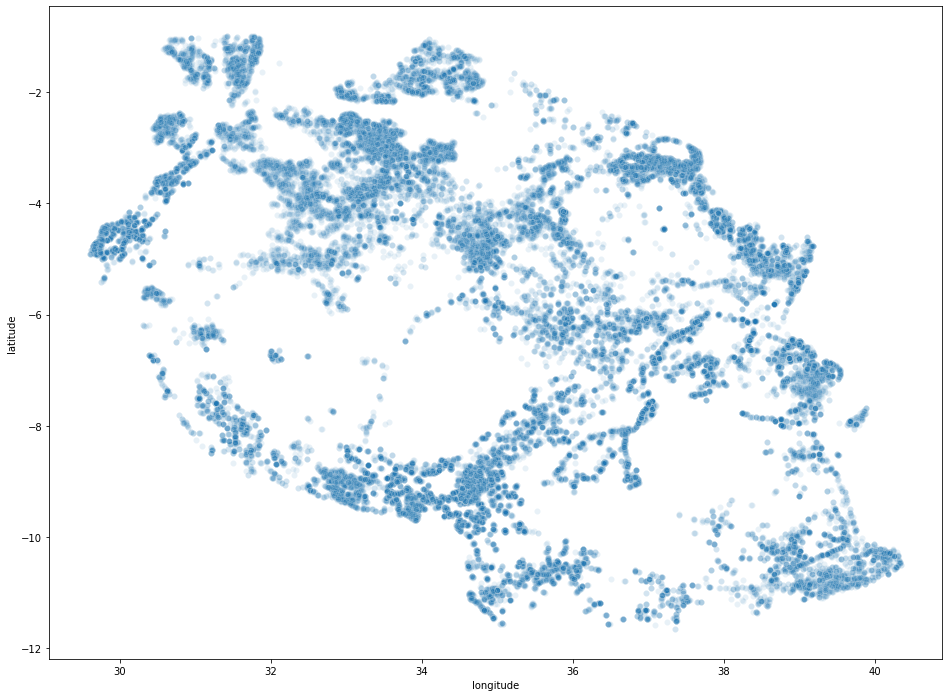

In [7]:
# waterpump locations
plt.figure(figsize=(16, 12))
ax = sns.scatterplot(x="longitude", 
                     y="latitude", 
                     data=df, 
                     alpha=0.1)

In [8]:
# Null latitude and longitude instances are hard to fill. 
# It would most likely result in bad data. 

df = df.dropna(subset=['latitude','longitude'])

###  K-Means Clustering 

There are two clustering algorithms that are useful for geospatial analysis. The first and more general is K-Means clustering, which relies on squared Euclidean distance. This can fall apart on large scale geospatial applications, but can be used in a general sense. 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


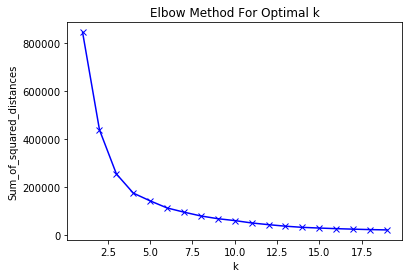

In [9]:
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    print(k)
    km = KMeans(n_clusters=k, n_jobs=-1, random_state = 42, verbose=10)
    km = km.fit(df[['longitude','latitude']])
    Sum_of_squared_distances.append(km.inertia_)
    
K = range(1,20)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It appears that the optimal number of clusters is 5

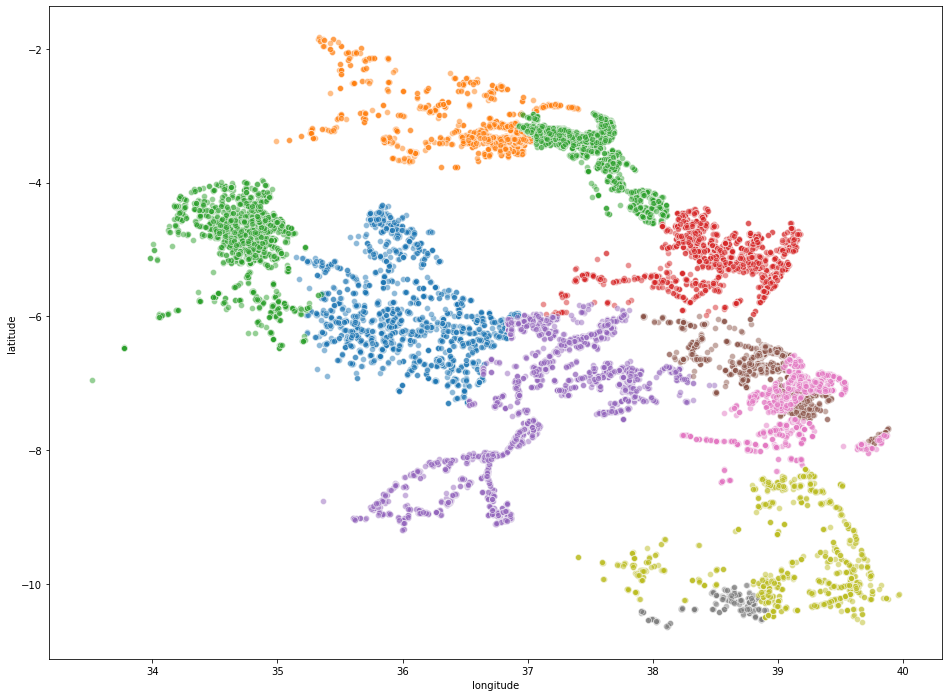

In [10]:
top_regions = df['district_code'].value_counts().index.tolist()
plt.figure(figsize=(16, 12))
for region in top_regions:
    ex_df = df[df['region_code'] == region]
    
    sns.scatterplot(x="longitude", 
                    y="latitude", 
                    data=ex_df,
                    alpha=0.5)


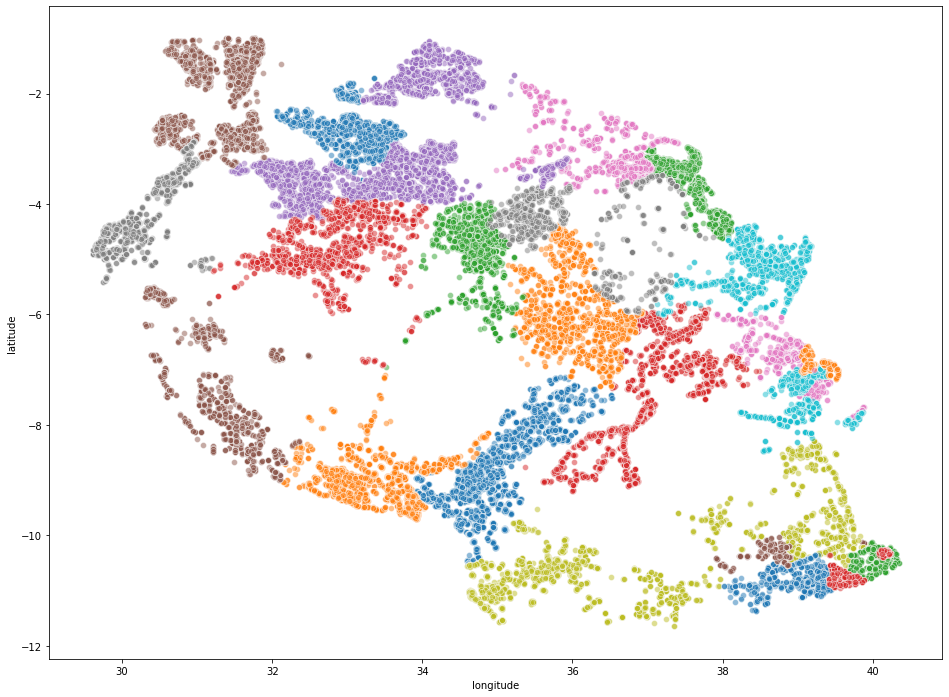

In [11]:
top_regions = df['region_code'].value_counts().index.tolist()


plt.figure(figsize=(16, 12))
for region in top_regions:
    ex_df = df[df['region_code'] == region]

    sns.scatterplot(x="longitude", 
                     y="latitude", 
                     data=ex_df,
                    alpha=0.5)

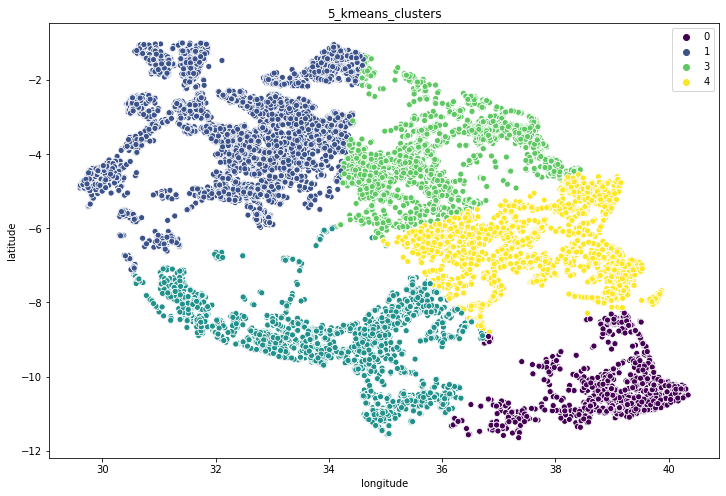

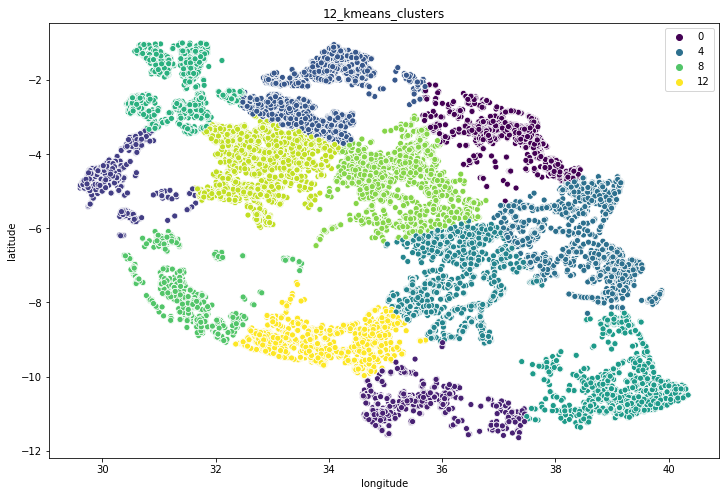

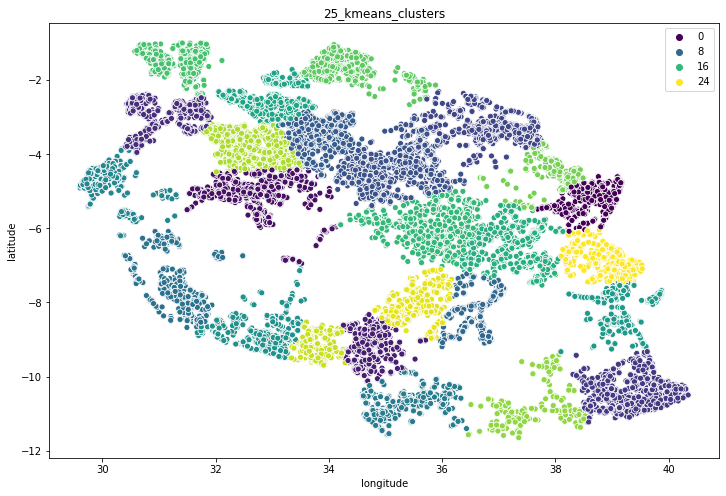

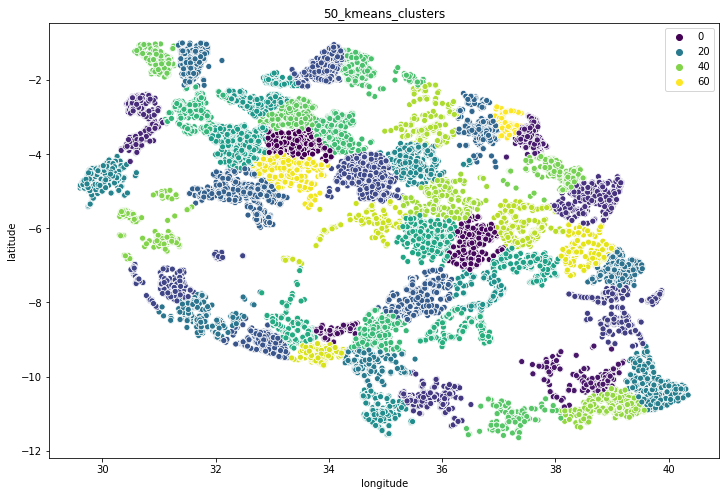

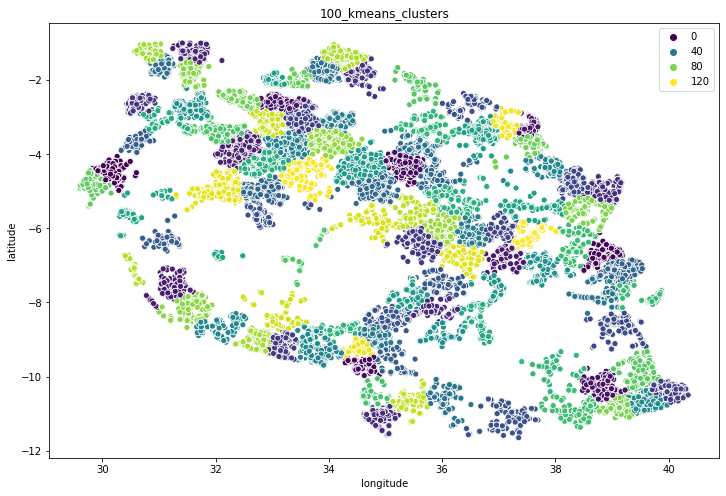

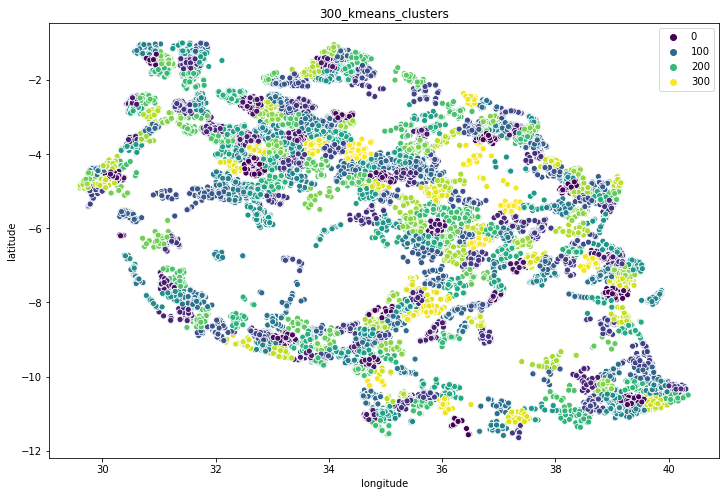

In [12]:
cdf = pd.DataFrame()

n_clusters = [5, 12, 25, 50, 100, 300]

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_jobs=3)
    kmeans.fit(df[['longitude','latitude']])
    y_kmeans = kmeans.predict(df[['longitude','latitude']])
    
    cdf[str(n)+'_kmeans_clusters'] = y_kmeans
    
    plt.figure(figsize=(12, 8))
    ax = (sns.scatterplot(x=df['longitude'], 
                         y=df['latitude'], 
                         hue=y_kmeans, 
                         palette='viridis')
         .set_title(str(n)+'_kmeans_clusters'))

### Spectral Clustering

Spectral clustering builds off the spectrum of the similarity matrix of the data. It can be especially useful for odd geometric patterns where Euclidean space clustering falls apart. For Geospatial applications it is optimal for large distances as the curvature of the earth becomes a factor. It can also be incredibly useful for Geospatial outlier detection as nodes with a low enough similarity are classified as "noise". 

Spectral Clustering requires the conversion of kilometers to radians for Latitude and Longitude data. 


In [16]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

Number of clusters:  8
Number of clusters:  8
Number of clusters:  8
Number of clusters:  8
Number of clusters:  8
Number of clusters:  8
Number of clusters:  8
Number of clusters:  9
Number of clusters:  9
Number of clusters:  7
Number of clusters:  26
Number of clusters:  26
Number of clusters:  25
Number of clusters:  24
Number of clusters:  23
Number of clusters:  22
Number of clusters:  19
Number of clusters:  19
Number of clusters:  17
Number of clusters:  15
Number of clusters:  73
Number of clusters:  73
Number of clusters:  63
Number of clusters:  56
Number of clusters:  48
Number of clusters:  49
Number of clusters:  48
Number of clusters:  44
Number of clusters:  41
Number of clusters:  36
Number of clusters:  167
Number of clusters:  167
Number of clusters:  138
Number of clusters:  122
Number of clusters:  111
Number of clusters:  110
Number of clusters:  105
Number of clusters:  98
Number of clusters:  92
Number of clusters:  85
Number of clusters:  347
Number of clusters

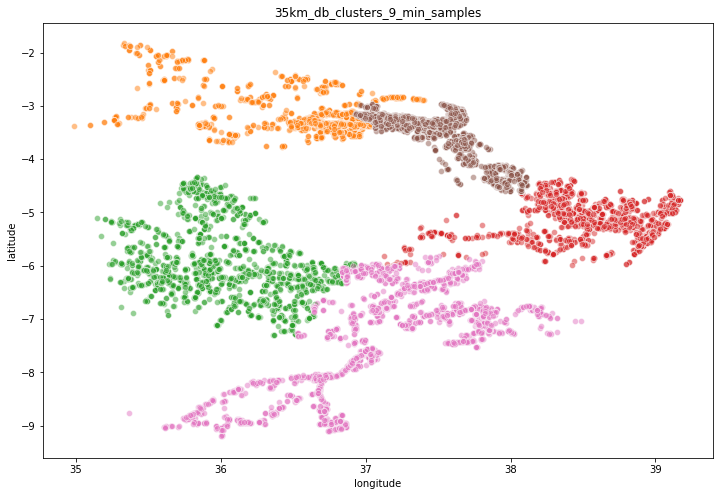

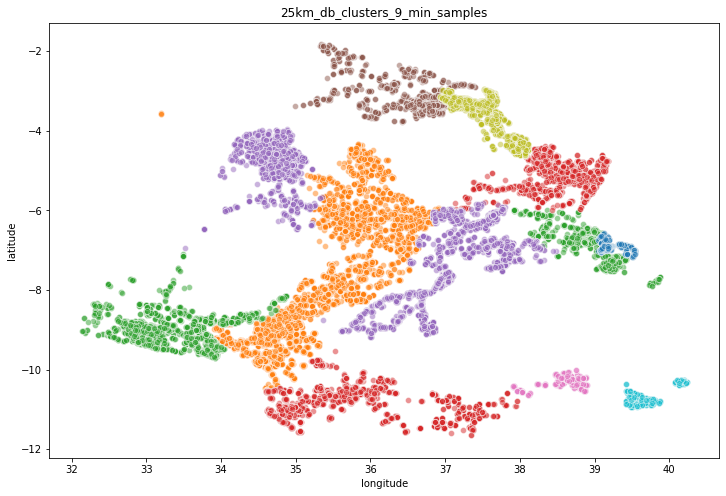

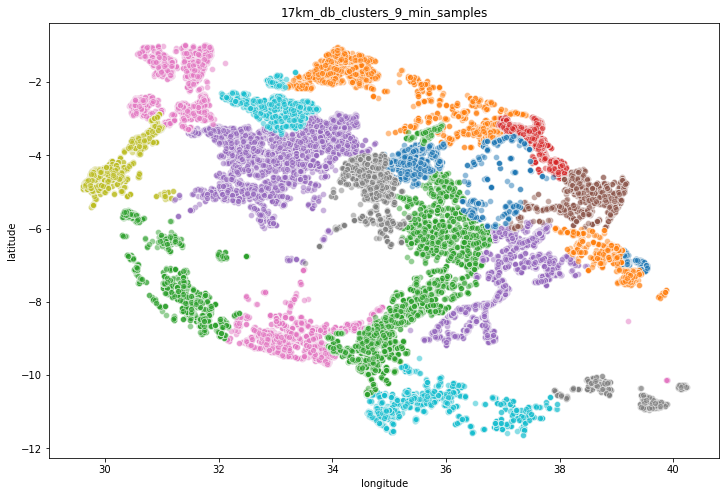

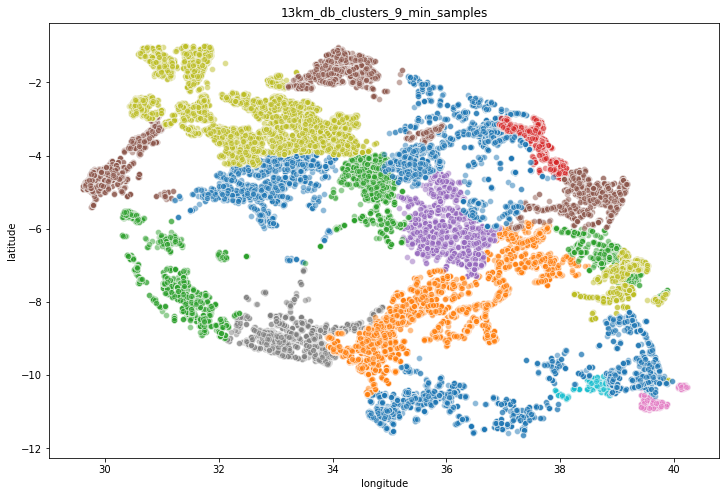

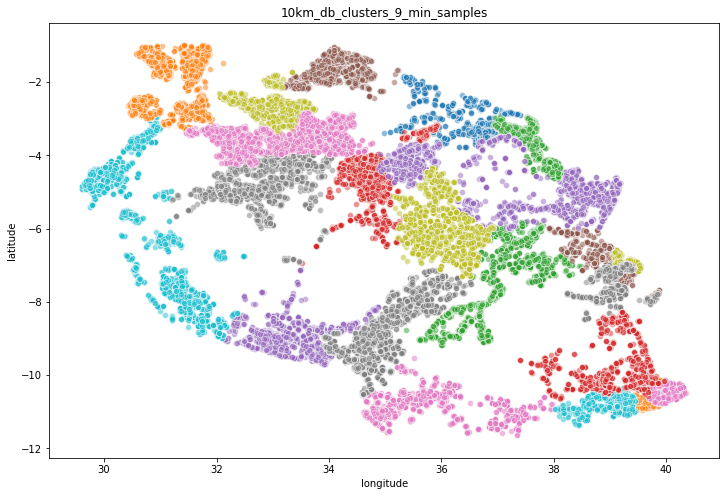

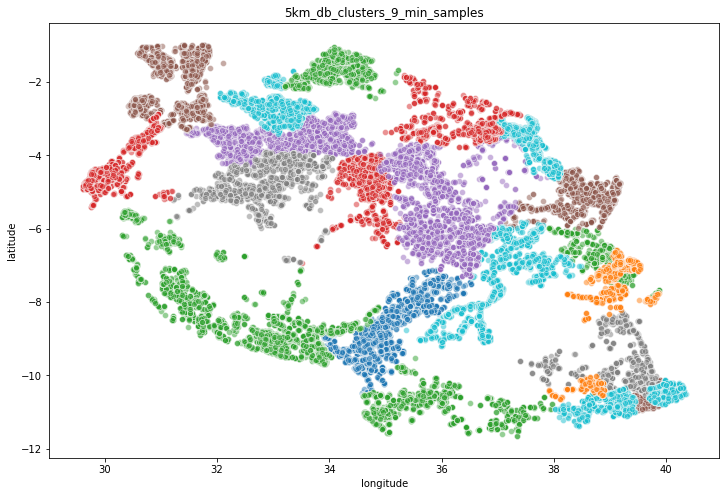

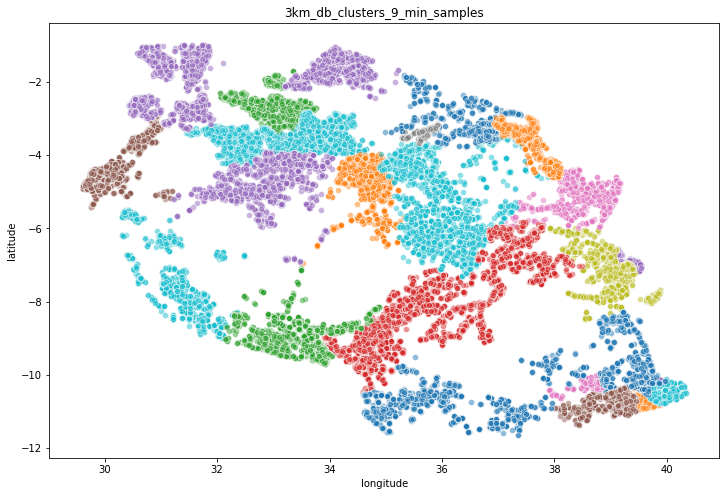

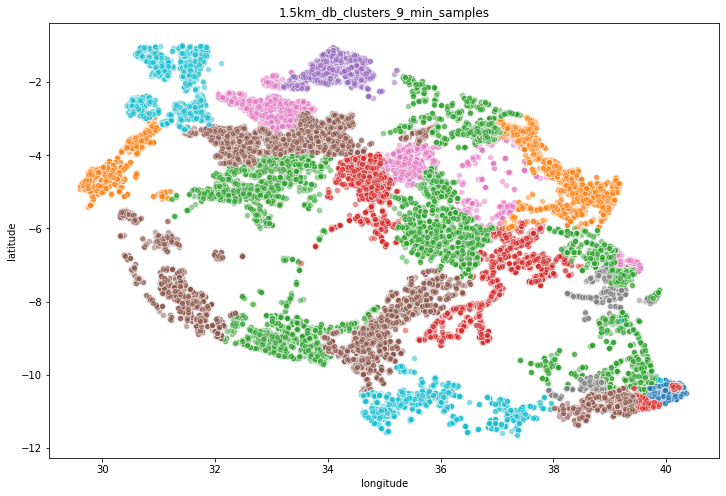

In [17]:
max_distances = [35, 25, 17, 13, 10, 5, 3, 1.5]
min_samples = np.arange(10)

for d in max_distances:
    for i in min_samples: 
    
        kms_per_radian = 6371.0088
        epsilon = d / kms_per_radian
        db = (DBSCAN(eps=epsilon, min_samples=i, 
                    algorithm='ball_tree', 
                    metric='haversine')
              .fit(np.radians(df[['latitude','longitude']])))

        cdf[str(d)+'km_db_clusters_'+str(i)+'_min_samples'] = db.labels_
        print('Number of clusters: ', cdf[str(d)+'km_db_clusters_'+str(i)+'_min_samples'].nunique())

        top_regions = cdf[str(d)+'km_db_clusters_'+str(i)+'_min_samples'].value_counts().index.tolist()

    plt.figure(figsize=(12, 8))
    for region in top_regions:
        ex_df = df[df['region_code'] == region]

        sns.scatterplot(x="longitude", 
                         y="latitude", 
                         data=ex_df, 
                         alpha=0.5).set_title(str(d)+'km_db_clusters_'+str(i)+'_min_samples')
